# Evaluating NWM Streamflow Predictions

In this notebook we will demonstrate how to fetch streamflow predictions from the NWM for a given area. We will also see how the predictions change over time, and use some simple operations to visualize their variation over time.

## Imports

First we import the libraries we'll need. PyNHD has useful wrappers around various web services that allow us to fetch hydrological data. S3FS and XArray are used to read NetCDF files from S3. SQL Alchemy and GeoPandas are used to construct dataframes from a PostGIS database.

In [1]:
from pynhd.pynhd import NHD, NHDPlusHR, WaterData
import os, s3fs
import xarray as xr
import geopandas as gpd
import sqlalchemy as sa

from datetime import datetime, timedelta

## Helper functions for flowline retrieval

These are two ways to get flowlines, either from the NHD web service using HyRiver's `pynhd` package, or from our database where we've ingested the same data. The NHD web service is more portable but slower.

In [2]:
def get_flowlines_from_db(huc):
    con = sa.create_engine(
        "{driver}://{user}:{password}@{host}/{database}".format(
            driver="postgresql+psycopg2",
            user=os.getenv("PGUSER"),
            password=os.getenv("PGPASSWORD"),
            host=os.getenv("PGHOST"),
            database="nhdplusv2",
        )
    )

    sql = f"""
        SELECT comid, shape
        FROM nhdflowline_network
        WHERE ST_Intersects(
            shape,
            ST_Transform(
                ST_SetSRID(
                    ST_GeomFromText('{huc.geometry[0].wkt}'),
                    4326),
                4269)
        )
    """
    
    return gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

In [3]:
def get_flowlines_from_web(huc):
    return NHD('flowline_mr').bygeom(huc.geometry[0].geoms[0])

## Pick an Area of Interest

We want to look at streamflow predictions for a particular area. In this example, we're looking at the Lower Schuylkill HUC-10 `0204020310`.

CPU times: user 588 ms, sys: 79.7 ms, total: 668 ms
Wall time: 593 ms


<AxesSubplot:>

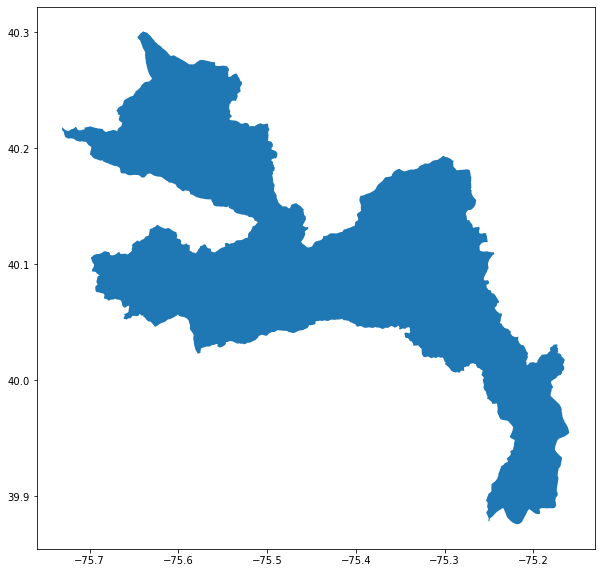

In [4]:
%%time

HUC = '0204020310'

huc = WaterData('wbd10_20201006').byid('huc10', HUC)
huc.geometry.plot(figsize=(10, 10))

Get flowlines contained within that shape

CPU times: user 130 ms, sys: 34.3 ms, total: 164 ms
Wall time: 285 ms


<AxesSubplot:>

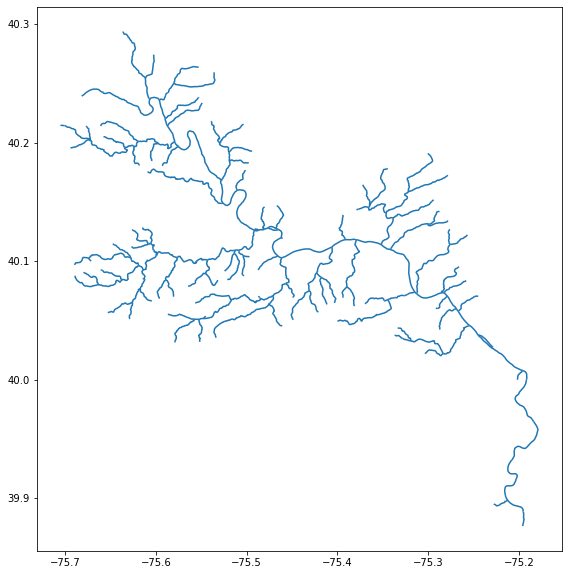

In [5]:
%%time

flowlines = get_flowlines_from_db(huc)
flowlines.plot(figsize=(10, 10))

## Fetch the NWM Short Range Forecast

We fetch the NWM Short Range forecast from the NetCDF files available in the offical S3 bucket `noaa-nwm-pds`, which allows anonymous access. For now, we only care about `streamflow`, so we drop the other variables. We use `h5netcdf` as the engine to read NetCDF files remotely.

_NOTE_: This step reads all the short range NetCDF files for the given day, often resulting in ~1.8GB of network transfer. That data is read into memory, using roughly ~7-10GB of RAM.

In [6]:
%%time

fs = s3fs.S3FileSystem(anon=True)
date = '20230312'

netcdf_url = f's3://noaa-nwm-pds/nwm.{date}/short_range/nwm.t*z.short_range.channel_rt.*.conus.nc'
fileset = [fs.open(file) for file in fs.glob(netcdf_url)]

ds = xr.open_mfdataset(fileset, engine='h5netcdf',
                       data_vars=['streamflow'], coords='minimal', compat='override',
                       drop_variables=['nudge', 'velocity', 'qSfcLatRunoff', 'qBucket', 'qBtmVertRunoff'])
ds

CPU times: user 49.6 s, sys: 6.34 s, total: 55.9 s
Wall time: 1min 55s


,Array,Chunk
Bytes,20.36 GiB,21.18 MiB
Shape,"(24, 41, 2776738)","(1, 1, 2776738)"
Count,7320 Tasks,984 Chunks
Type,float64,numpy.ndarray


## Subset the dataset to only the streams within the HUC

The NHD COMID dataset and the NWM Feature IDs don't have an exact overlap. We intersect the two to limit our work to those streams found in both.

In [7]:
%%time

nhd_reaches = set([int(f) for f in flowlines['comid']])
nwm_reaches = set(ds.feature_id.values)

common_reaches = list(set(nwm_reaches).intersection(set(nhd_reaches)))

CPU times: user 280 ms, sys: 42.9 ms, total: 323 ms
Wall time: 321 ms


## Pick a single feature to analyze

For every feature, for every hour of the day, we have 18 forecast values, for a total of 432. At midnight there are forecasts for 1am, 2am, ..., 6pm, at 1am there are forecasts for 2am, 3am, ..., 7pm, and so on. To observe how these forecasts change with time, we pick a single representative feature to analyze.

Every feature has a `feature_id`. For this feature, there are 24 `reference_time`s, corresponding to the hour of the day. For each `reference_time`, there are 18 `time`s each, corresponding to the hour of the prediction.

CPU times: user 44.3 s, sys: 8.23 s, total: 52.6 s
Wall time: 25.3 s


streamflow
reference_time      time                feature_id            
2023-03-12 00:00:00 2023-03-12 01:00:00 4784835      90.149998
                    2023-03-12 02:00:00 4784835      91.349998
                    2023-03-12 03:00:00 4784835      92.279998
                    2023-03-12 04:00:00 4784835      92.989998
                    2023-03-12 05:00:00 4784835      93.509998
...                                                        ...
2023-03-12 23:00:00 2023-03-13 13:00:00 4784835      90.729998
                    2023-03-13 14:00:00 4784835      90.849998
                    2023-03-13 15:00:00 4784835      90.979998
                    2023-03-13 16:00:00 4784835      91.119998
                    2023-03-13 17:00:00 4784835      91.299998

[984 rows x 1 columns]

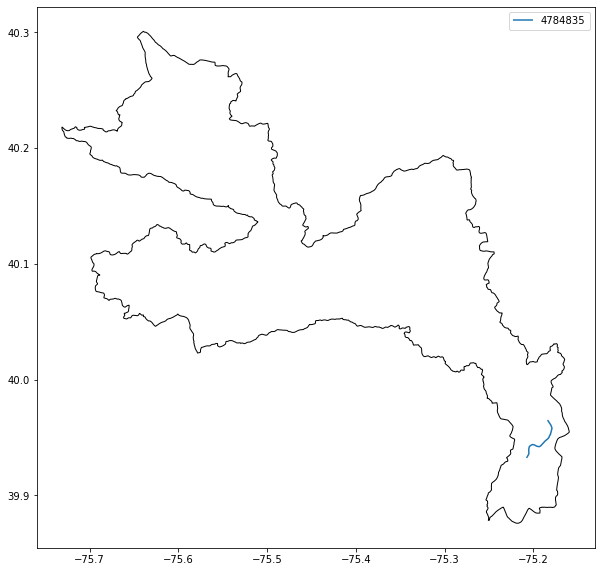

In [8]:
%%time

FEATURE_ID = 4784835

ax = huc.plot(facecolor="none", edgecolor="k", figsize=(10, 10))
flowlines[flowlines.comid == FEATURE_ID].plot(ax=ax, label=FEATURE_ID)
ax.legend()

sub_ds = ds.sel(feature_id=[FEATURE_ID])
df = sub_ds['streamflow'].to_dataframe()
df

In [9]:
sub_df = df.reset_index().drop(columns=['feature_id']).set_index(keys=['reference_time', 'time'])

## Streamflow predicted for next 18 hours at each reference time

This visualization shows the predicted streamflow for the next 18 hours starting at each `reference_time`. The x-axis is `time`, and has multiple values for each `reference_time`. The y-axis is `streamflow`. Each line corresponds to a `reference_time`. This shows how the predictions change at each iteration.

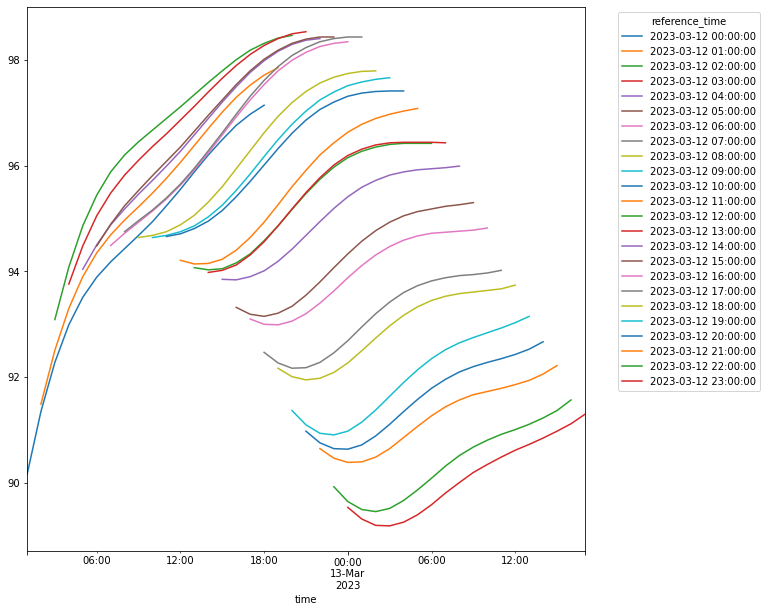

In [10]:
reference_times = list(sub_df.index.get_level_values(0).unique())
ax = sub_df.loc[reference_times[0]].plot(figsize=(10, 10))
for rt in reference_times[1:]:
    sub_df.loc[rt].plot(ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=reference_times, title='reference_time')

## Change in predicted streamflow for a given time

This is an inverse of the previous graph: each line corresponds to a `time`, and we see how it's prediction changes over different `reference_time`s.

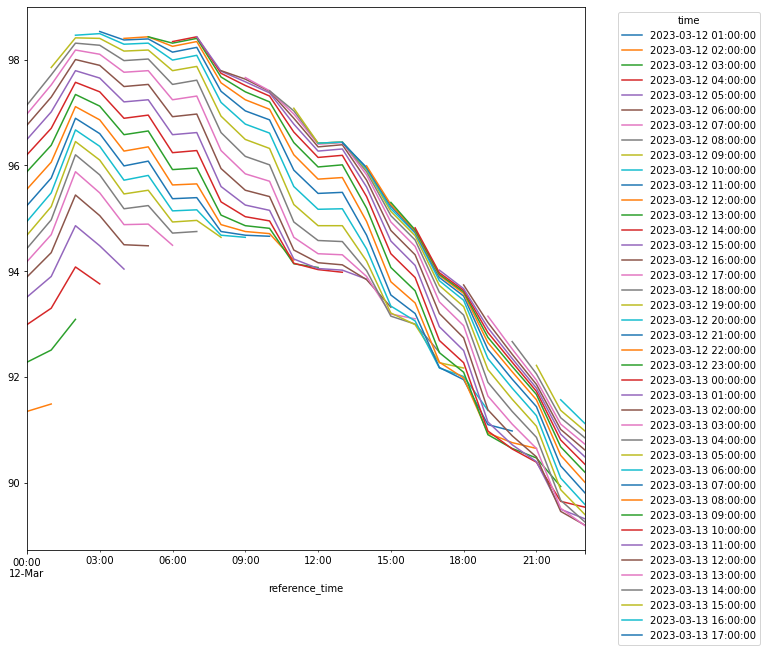

In [16]:
times = list(sub_df.index.get_level_values(1).unique())
ax = sub_df[sub_df.index.isin([times[0]], level=1)].reset_index().drop(columns=['time']).set_index(keys=['reference_time']).plot(figsize=(10, 10))
for t in times[1:]:
    sub_df[sub_df.index.isin([t], level=1)].reset_index().drop(columns=['time']).set_index(keys=['reference_time']).plot(ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=times, title='time')

## Standard deviation of prediction by hour

Let's quantify that change by calculating the standard deviation by hour. The normal-ish curve seen below is explained by the fact that there are more predictions in the middle than there are on the edges.

<AxesSubplot:xlabel='time'>

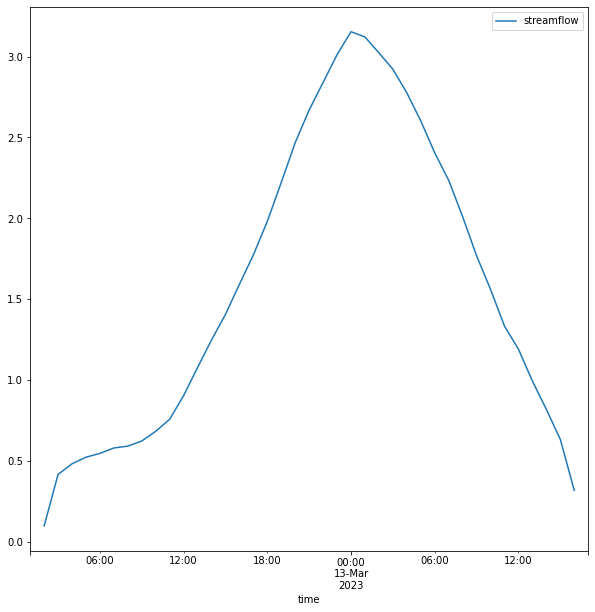

In [12]:
sub_df.groupby('time').std().plot(figsize=(10, 10))

## Average deviation for this reach

In [13]:
sub_df.groupby('time').std().mean()

streamflow    1.573823
dtype: float64

## Average deviation for every reach in the HUC

Now that we have a scalar value for the reach, we can do the same calculation for every reach in the HUC. Once we have that distribution, we can also visualize it. In the visualization we see that reaches along the main stream have more variation than those on the edges. This makes sense: as the main stream has a lot of small streams contributing to it, so all their small variations add up to large ones.

CPU times: user 3min 24s, sys: 35.1 s, total: 3min 59s
Wall time: 2min 51s


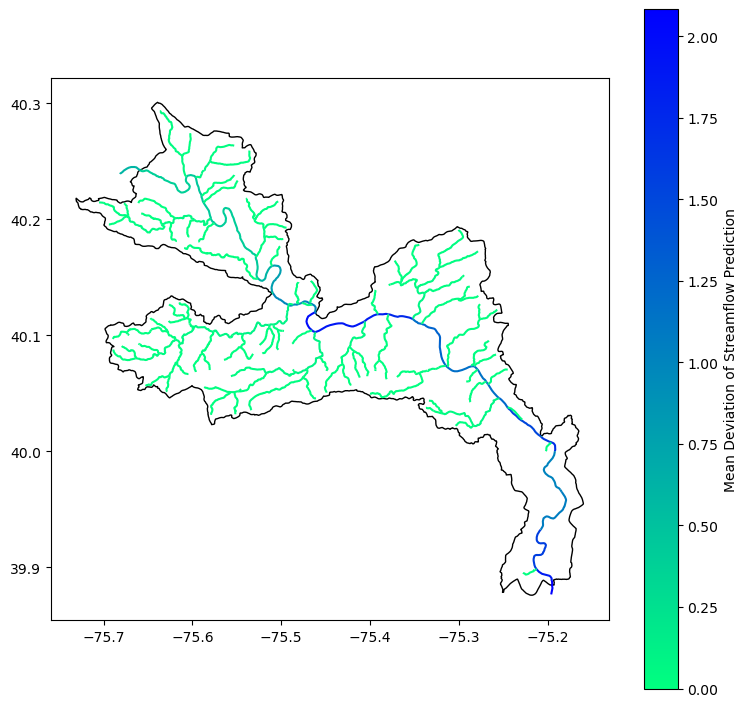

In [14]:
%%time

sub_ds2 = ds.sel(feature_id=common_reaches)['streamflow']
mean_std_per_reach = sub_ds2.groupby('feature_id').std('time').mean('reference_time').to_dataframe()

joined = flowlines.merge(mean_std_per_reach, left_on='comid', right_on='feature_id')

ax = huc.plot(facecolor="none", edgecolor="k", figsize=(9, 9))
joined.plot(ax=ax, column="streamflow", cmap='winter_r', legend=True, legend_kwds={"label": "Mean Deviation of Streamflow Prediction"})
ax.figure.set_dpi(100)